나만의 Augmented Image 만들어 저장하기

In [25]:
from tqdm import tqdm
import os
from glob import glob
from torchvision.utils import save_image
from torchvision import transforms as T
from PIL import Image

import pandas as pd
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
# from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [53]:
labels = pd.read_csv('/opt/ml/input/data/train/train.csv')
old_labels = labels.loc[labels.age >= 60]
old_labels.head()

,id,gender,race,age,path
416,001038,male,Asian,60,001038_male_Asian_60
422,001043,male,Asian,60,001043_male_Asian_60
427,001047,male,Asian,60,001047_male_Asian_60
443,001063,female,Asian,60,001063_female_Asian_60
476,001101,male,Asian,60,001101_male_Asian_60


In [3]:
len(old_labels)

192

In [4]:
base = '/opt/ml/input/data/train/images/'
old_img = []
for path in old_labels['path']:
    img_folder = glob(os.path.join(base, path, '*'))
    for img in img_folder:
        old_img.append(img)
old_img[0]

'/opt/ml/input/data/train/images/001038_male_Asian_60/mask2.jpg'

In [6]:
len(old_img)//7

192

Augmentation 실험해보기

In [8]:
transform = T.Compose([
    T.RandomHorizontalFlip(p=1),
    T.RandomPerspective(distortion_scale=0.12, p=1.0),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(2, 5)),
    T.CenterCrop((505, 375)),
    T.Resize((512, 384))
])

In [51]:
cutout = A.Compose([
    A.HorizontalFlip(p=1),
    A.OneOf([
        A.MotionBlur(p=1),
        A.OpticalDistortion(p=1),
        A.GaussNoise(p=1)                 
    ], p=1),
    A.OneOf([
        A.Cutout(p=1, num_holes=10, max_h_size=10, max_w_size=6),
        A.GridDistortion(p=1, num_steps=5, interpolation=1, border_mode=1, value=(0, 0, 0)),
    ], p=1),
    ToTensorV2(),
])

<class 'torch.Tensor'> <class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'PIL.Image.Image'>
<class 'torch.Tensor'> <class 'PIL.Image.Image'>


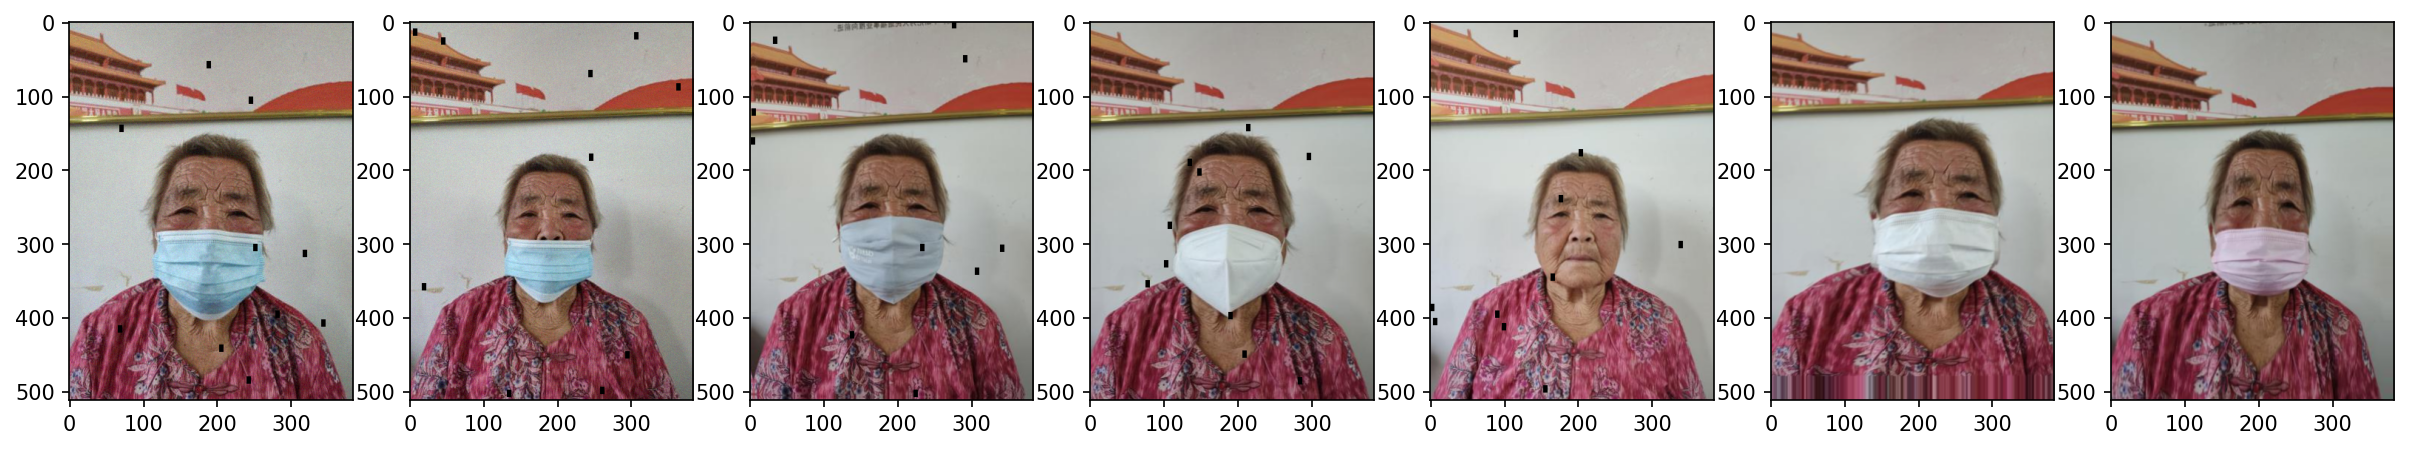

In [52]:
P = 20
fig, axes = plt.subplots(1, 7, figsize=(20,20), dpi=150)
for j in range(7):
    n = j + 7*P
    image = cv2.imread(old_img[n])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cutout(image=image)
    image = image['image']
    axes[j].imshow(T.ToPILImage()(image))
    print(type(image), type(T.ToPILImage()(image)))
plt.show()

지정된 경로에 augmentation image folder를 새로 생성하고 그 안에 이미지 저장

In [90]:
def save_aug(transform, name, labels):
    base_dir = '/opt/ml/input/data/train/'
    aug_dir = '/opt/ml/input/data/train/imgaug/' + name + '/'
    train_dir = os.path.join(base_dir, 'images/')
    
# transform 이름(name)에 대한 폴더를 생성합니다
    if not os.path.exists(aug_dir):
            os.makedirs(aug_dir)
            
# argument labels의 path들을 읽어주며 이미지를 열고 train/images와 동일하게 폴더를 생성합니다
    for path in tqdm(labels['path']):
        if not os.path.exists(os.path.join(aug_dir, path)):
            os.makedirs(os.path.join(aug_dir, path))
        img_folder = glob(os.path.join(train_dir, path, '*'))
        
# 원본 이미지들을 읽어들여 생성된 폴더에 argument로 넣어준 transform이 적용된 이미지를 저장합니다
#         for img in img_folder:
#             im = Image.open(img)
#             im = transform(im)
#             file_name = img.split('/')[-1]
#             save_image(im, os.path.join(aug_dir, path, file_name))
        for image in img_folder:
            file_name = image.split('/')[-1]
            image = cv2.imread(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = transform(image=image)
            image = image['image']
            cv2.imwrite(os.path.join(aug_dir, path, file_name), image)
#             image = Image.fromarray(image)
#             print(type(image))
#             A.load(image, os.path.join(aug_dir, path, file_name))
#             image.save(os.path.join(aug_dir, path, file_name))

위와 다르게 이미지를 저장할 때는 반드시 맨 마지막에 ToTensor()를 추가해야함

In [10]:
distortion = T.Compose([
    T.RandomHorizontalFlip(p=1),
    T.ColorJitter(brightness=0.1, contrast=0.5, saturation=0.1, hue=0),
    T.RandomPerspective(distortion_scale=0.12, p=1.0),
#     T.ToTensor()를 반드시 마지막에 해줘야합니다!
    T.ToTensor()
])

save_aug(distortion, 'distortion', old_labels)

100%|██████████| 192/192 [01:30<00:00,  2.13it/s]


In [11]:
blur = T.Compose([
    T.RandomHorizontalFlip(p=0.7),
    T.ColorJitter(brightness=0.4, contrast=0.6, saturation=0.1, hue=0.05),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(2, 5)),
    T.ToTensor()
])

save_aug(blur, 'blur', old_labels)

100%|██████████| 192/192 [03:13<00:00,  1.01s/it]


In [91]:
cutout = A.Compose([
    A.HorizontalFlip(p=1),
    A.OneOf([
        A.MotionBlur(p=1),
        A.OpticalDistortion(p=1),
        A.GaussNoise(p=1)                 
    ], p=1),
    A.OneOf([
        A.Cutout(p=1, num_holes=10, max_h_size=10, max_w_size=6),
        A.GridDistortion(p=1, num_steps=5, interpolation=1, border_mode=1, value=(0, 0, 0)),
    ], p=1),
    ToTensorV2(),
])

save_aug(cutout, 'cutout', old_labels)

  0%|          | 0/192 [00:00<?, ?it/s]


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


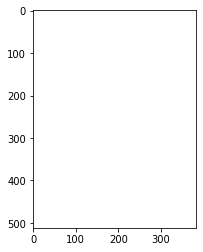

In [77]:
im = Image.open('/opt/ml/input/data/train/imgaug/cutout/001047_male_Asian_60/mask1.jpg')
plt.imshow(im)